In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Arial"
    }
</style>

### **Climate Forecasting Model with Prophet: Exploratory Data Analysis and Statistical Comparison**
---
The dataset consist of 4 parameters (mean temperature, humidity, wind speed, and mean pressure) measured during a period of 5 years approximately. The objective of this project is to develop a forecasting model that can predict the values of a variable of interest, in this case, temperature. To achieve this, we will first conduct an exploratory data analysis to understand the characteristics of the data.  We will then utilize the Prophet package to construct a predictive model, incorporating additional variables such as humidity and average pressure to enhance the model's performance. Finally, we will perform a statistical analysis to compare the model's performance with and without the additional regressor variables.

In [2]:
# Packages 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf 
import plotly.io as pio

pio.renderers.default = "svg"
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams['figure.max_open_warning'] = 0
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Dataframe 
data = pd.read_csv('daily_climate.csv', parse_dates = ['date'], index_col = 'date') # The two datasets from Kaggle were previously merged
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1575 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1575 non-null   float64
 1   humidity      1575 non-null   float64
 2   wind_speed    1575 non-null   float64
 3   meanpressure  1575 non-null   float64
dtypes: float64(4)
memory usage: 61.5 KB
None


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000,84.500,0.000,1015.667
2013-01-02,7.400,92.000,2.980,1017.800
2013-01-03,7.167,87.000,4.633,1018.667
2013-01-04,8.667,71.333,1.233,1017.167
2013-01-05,6.000,86.833,3.700,1016.500


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1575.000,25.232,7.337,6.000,18.517,27.167,31.143,38.714
humidity,1575.000,60.420,16.956,13.429,49.750,62.381,72.125,98.000
wind_speed,1575.000,6.904,4.509,0.000,3.700,6.370,9.262,42.220
meanpressure,1575.000,1010.590,175.298,-3.042,1001.875,1009.000,1015.183,7679.333


In [5]:
# Date features for data analysis
def create_features_timeseries(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['date'] = data.index.date
    
    return data
    
data = create_features_timeseries(data)
data.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day,dayofweek,date
date,,,,,,,,,
2013-01-01,10.000,84.500,0.000,1015.667,2013,1,1,1,2013-01-01
2013-01-02,7.400,92.000,2.980,1017.800,2013,1,2,2,2013-01-02
2013-01-03,7.167,87.000,4.633,1018.667,2013,1,3,3,2013-01-03
2013-01-04,8.667,71.333,1.233,1017.167,2013,1,4,4,2013-01-04
2013-01-05,6.000,86.833,3.700,1016.500,2013,1,5,5,2013-01-05


### **Exploratory Data Analysis**
---
First, we plot each time series to observe the behavior of each parameter across the years.

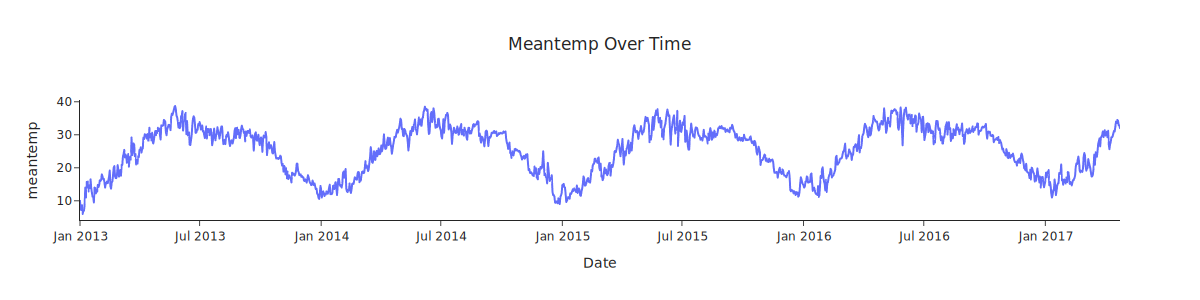

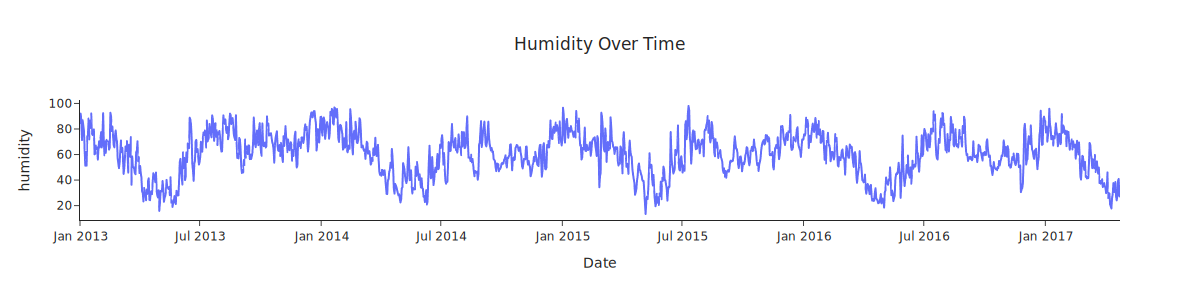

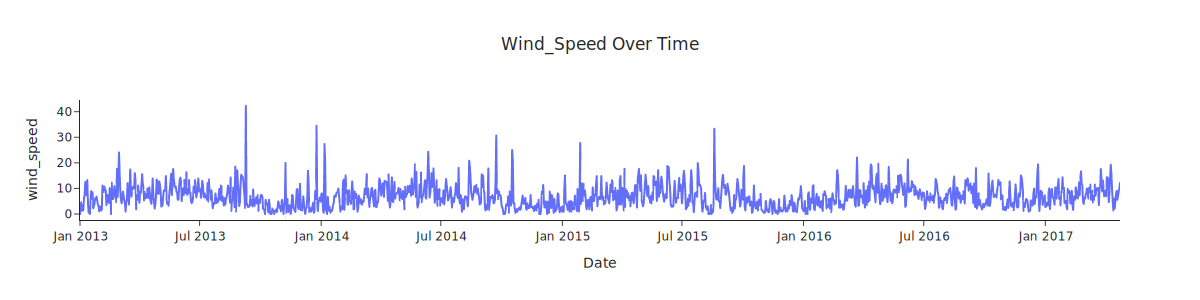

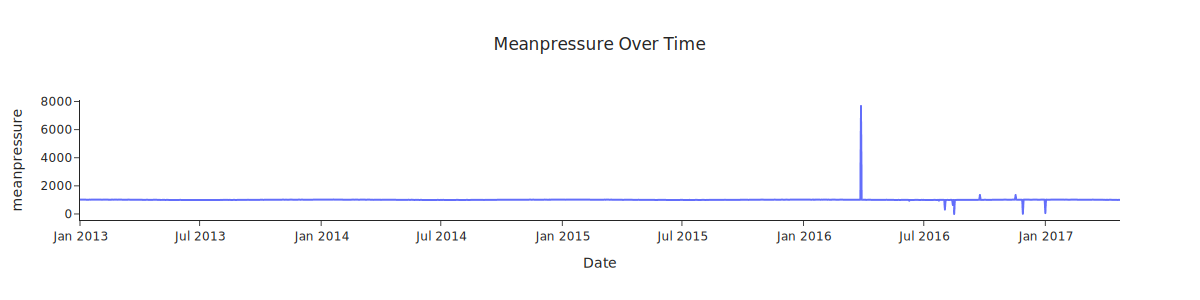

In [6]:
for column in data.columns:
    if column in ['meantemp', 'humidity', 'wind_speed', 'meanpressure']:
        fig = px.line(data, x=data.index, y = column, title=f'{column.title()} Over Time')
        fig.update_layout(template='simple_white', title_x=0.5, xaxis_title="Date", width = 1200, height = 300)
        fig.show()

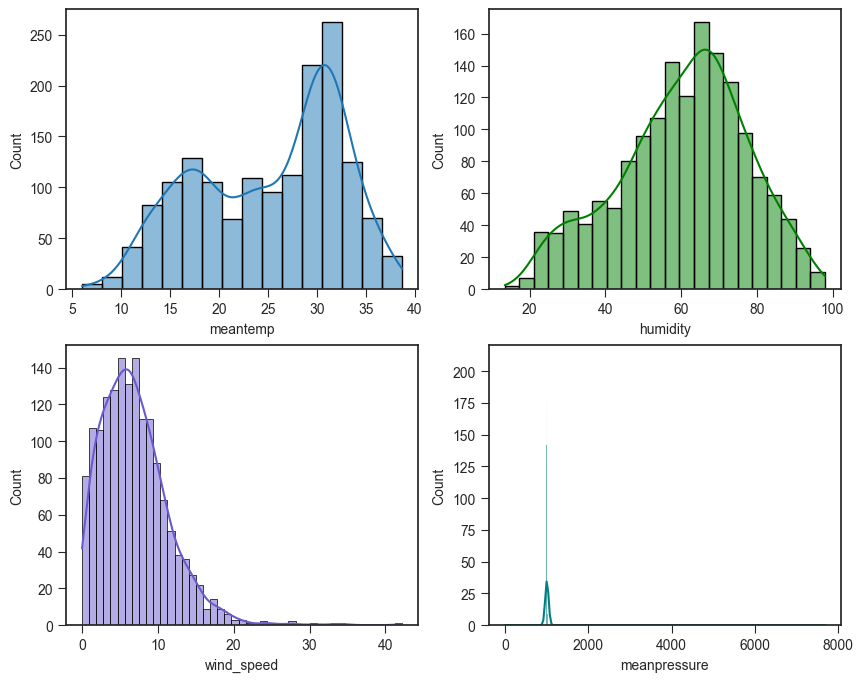

In [7]:
# Histograms to visualize the distibution of each variable
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(data=data, x="meantemp", ax=ax[0][0], kde=True)
sns.histplot(data=data, x="humidity", ax=ax[0][1], kde=True, color='green')
sns.histplot(data=data, x="wind_speed", ax=ax[1][0], kde=True, color='slateblue')
sns.histplot(data=data, x="meanpressure", ax=ax[1][1], kde=True, color='teal')

plt.show()

Using statsmodels we can decompose each time series using seasonal decompose. With this approximation, we can visually observe trends in data. In particular, the analysis shows an increase in mean temperature over the years, and a decrease in humidity.

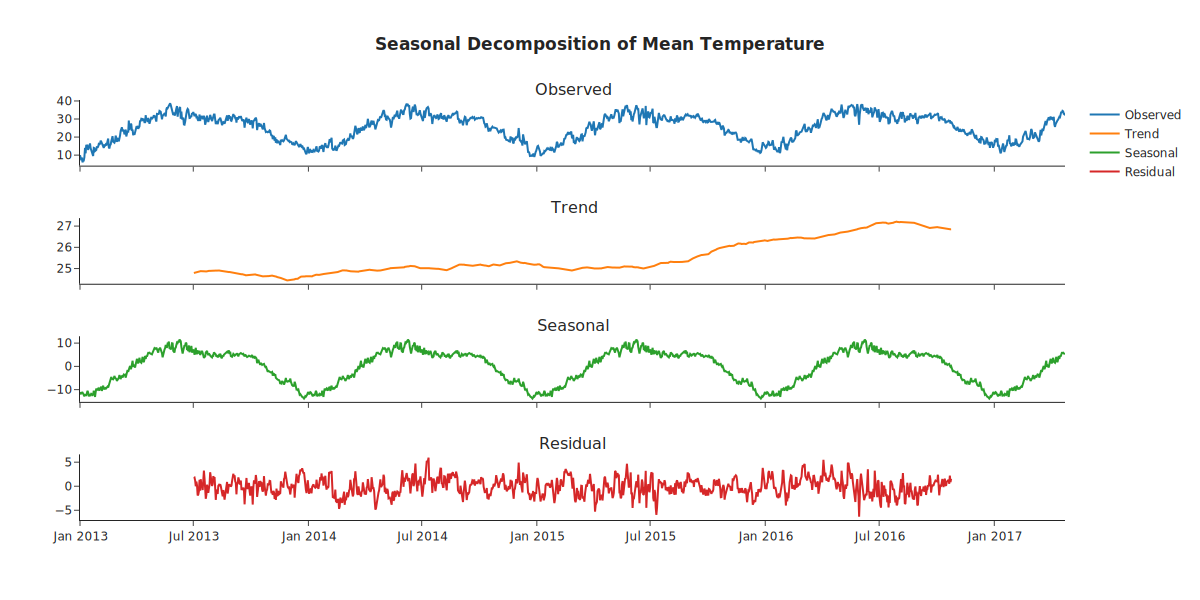

In [31]:
# Seasonal decomposition of mean temperature
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['meantemp'], model = 'additive', period = 365)

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

traces = [
    go.Scatter(x=data.index, y=decomposition.observed, mode='lines', name='Observed'),
    go.Scatter(x=data.index, y=decomposition.trend, mode='lines', name='Trend'),
    go.Scatter(x=data.index, y=decomposition.seasonal, mode='lines', name='Seasonal'),
    go.Scatter(x=data.index, y=decomposition.resid, mode='lines', name='Residual')
]

for i, trace in enumerate(traces):
    fig.add_trace(trace, row=i+1, col=1)

fig.update_layout(template= 'simple_white',height=600, width = 1200, title='<b>Seasonal Decomposition of Mean Temperature</b>', title_x=0.5)
fig.show('svg')

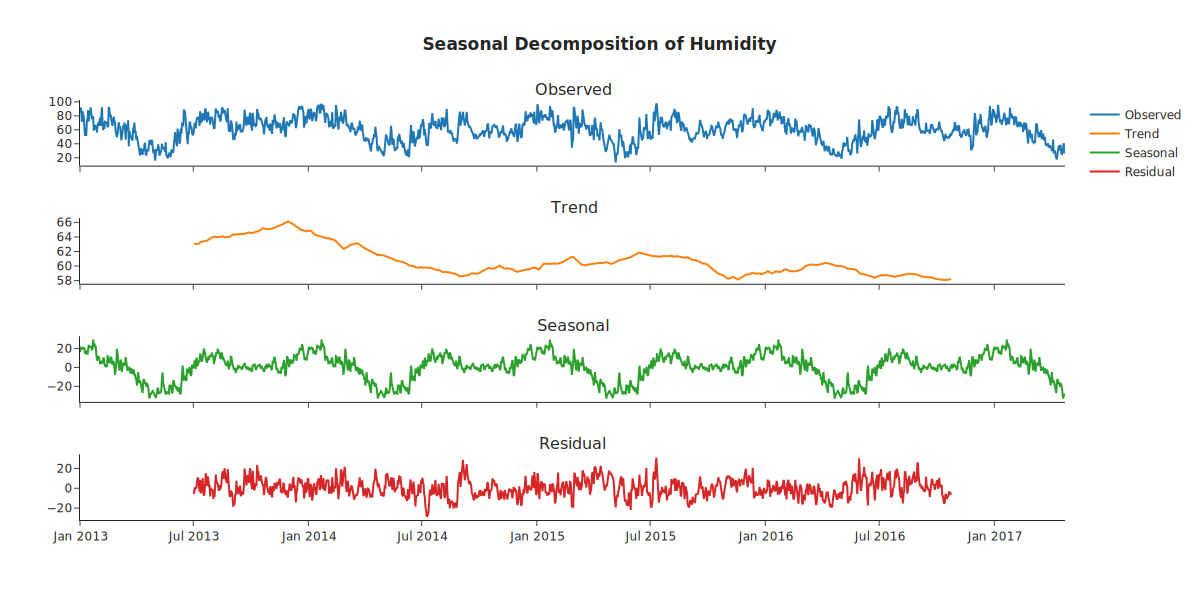

In [32]:
# Seasonal decomposition of humidity
decomposition = seasonal_decompose(data['humidity'], model = 'additive', period = 365)

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

traces = [
    go.Scatter(x=data.index, y=decomposition.observed, mode='lines', name='Observed'),
    go.Scatter(x=data.index, y=decomposition.trend, mode='lines', name='Trend'),
    go.Scatter(x=data.index, y=decomposition.seasonal, mode='lines', name='Seasonal'),
    go.Scatter(x=data.index, y=decomposition.resid, mode='lines', name='Residual')
]

for i, trace in enumerate(traces):
    fig.add_trace(trace, row=i+1, col=1)

fig.update_layout(template= 'simple_white',height=600, width = 1200, title='<b>Seasonal Decomposition of Humidity</b>', title_x=0.5)
fig.show('svg')

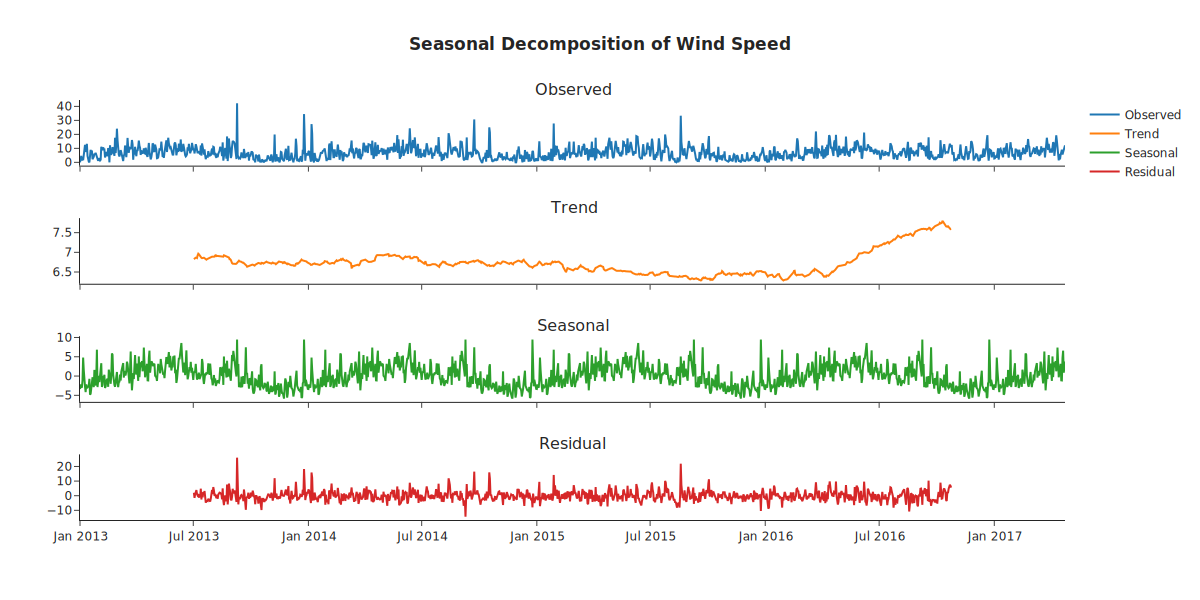

In [33]:
# Seasonal decomposition of wind speed
decomposition = seasonal_decompose(data['wind_speed'], model = 'additive', period = 365)

fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])

traces = [
    go.Scatter(x=data.index, y=decomposition.observed, mode='lines', name='Observed'),
    go.Scatter(x=data.index, y=decomposition.trend, mode='lines', name='Trend'),
    go.Scatter(x=data.index, y=decomposition.seasonal, mode='lines', name='Seasonal'),
    go.Scatter(x=data.index, y=decomposition.resid, mode='lines', name='Residual')
]

for i, trace in enumerate(traces):
    fig.add_trace(trace, row=i+1, col=1)

fig.update_layout(template= 'simple_white',height=600, width = 1200, title='<b>Seasonal Decomposition of Wind Speed</b>', title_x=0.5)
fig.show()

We can also analyze seasonal trends by plotting the mean values of each month across the years. In general, we observe an increase in temperature and wind speed (and a decrease in humidity) during summer months.

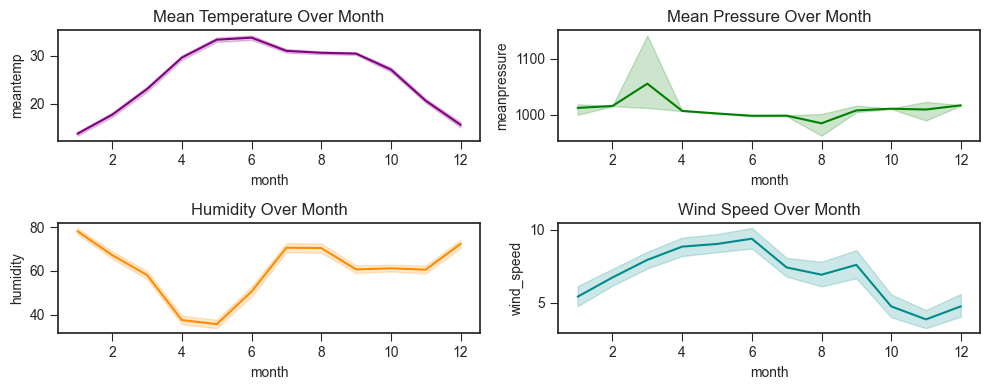

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

sns.lineplot(x='month', y='meantemp', data=data, color='purple', ax=axes[0][0])
sns.lineplot(x='month', y='humidity', data=data, color='darkorange', ax=axes[1][0])
sns.lineplot(x='month', y='meanpressure', data=data, color='green', ax=axes[0][1])
sns.lineplot(x='month', y='wind_speed', data=data, color='darkcyan', ax=axes[1][1])
axes[0][0].set_title('Mean Temperature Over Month')
axes[1][0].set_title('Humidity Over Month')
axes[0][1].set_title('Mean Pressure Over Month')
axes[1][1].set_title('Wind Speed Over Month')

plt.tight_layout()
plt.show()

We can also utilize scatter plots to visually adress correlation between the variables of the data set.

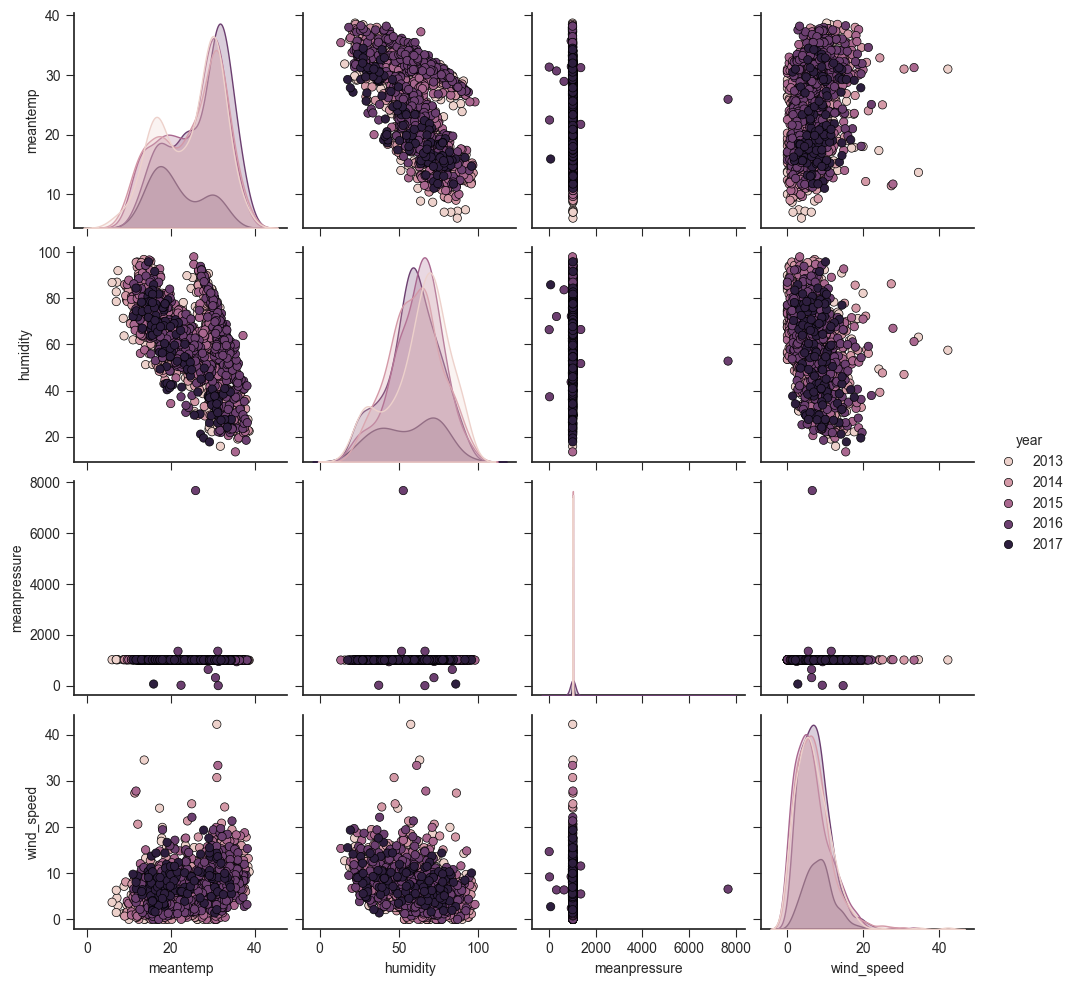

In [12]:
corr_data = data[['meantemp', 'humidity', 'meanpressure', 'wind_speed','year']]
g = sns.pairplot(corr_data, hue="year", plot_kws={'edgecolor': 'black'})

Using a correlation analysis and asuming a simple linear model, we can quantify the results visualized previously. Consistent with the previous results, mean temperature is negatively correlated with humidity and possitively correlated with wind speed. The slow increase in temperature across years is also quantified with a low correlation between the variables 'year' and 'meantemp'.

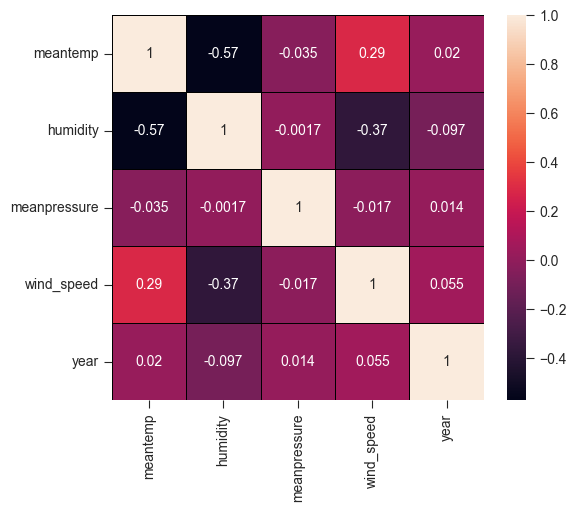

In [13]:
# Correlation analysis
corr_data = data[['meantemp', 'humidity', 'meanpressure', 'wind_speed','year']]
f, ax = plt.subplots(figsize = (6,5))
sns.heatmap(corr_data.corr(), annot = True, linewidths = 0.5, linecolor = "black", ax = ax)
plt.show()

### **Construction of the Forecasting Model (Prophet)**
---
Considering that the mean pressure stays almost as a constant value over the years and does not show a correlation with the mean temperature, we will exclude it from the forecasting model. Prothet model works with 'ds' (which acts as the independent variable) and 'y' (the variable of interest) variables as inputs. First, we will make the train and test datasets.

In [14]:
# Train dataset
df = data[['meantemp', 'humidity', 'wind_speed']]
train_size = int(len(df) * 0.7) # 30% of the data will be used for testing
train, test = df.iloc[:train_size], df.iloc[train_size:]

train_prophet = train.reset_index().rename(columns={'date': 'ds', 'meantemp': 'y'})
train_prophet.head()

,ds,y,humidity,wind_speed
0,2013-01-01,10.000,84.500,0.000
1,2013-01-02,7.400,92.000,2.980
2,2013-01-03,7.167,87.000,4.633
3,2013-01-04,8.667,71.333,1.233
4,2013-01-05,6.000,86.833,3.700


In [15]:
# Test dataset
test_prophet = test.reset_index().rename(columns={'date': 'ds', 'meantemp': 'y'})
test_prophet.head()

,ds,y,humidity,wind_speed
0,2016-01-08,15.500,83.250,7.888
1,2016-01-09,15.857,65.143,8.471
2,2016-01-10,15.625,74.375,2.775
3,2016-01-11,15.750,74.875,1.625
4,2016-01-12,18.000,69.688,6.031


The first model will only take into account the dependent variable (date) and the variable of interest (mean temperature)

In [16]:
# Model training 
from prophet import Prophet 
simple_model = Prophet()
simple_model.fit(train_prophet) 

22:54:03 - cmdstanpy - INFO - Chain [1] start processing
22:54:03 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Model testing and prediction
future = simple_model.make_future_dataframe(periods = len(test_prophet), freq = 'D') # 'Future' dataframe
forecast = simple_model.predict(future)
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

In [18]:
# Model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse = mean_squared_error(test_prophet['y'], predicted['yhat'])
r2 = r2_score(test_prophet['y'], predicted['yhat'])
print(f'Test MSE: {mse}]')
print(f'Test R²: {r2}')

Test MSE: 6.008194071042396]
Test R²: 0.8799009477414343


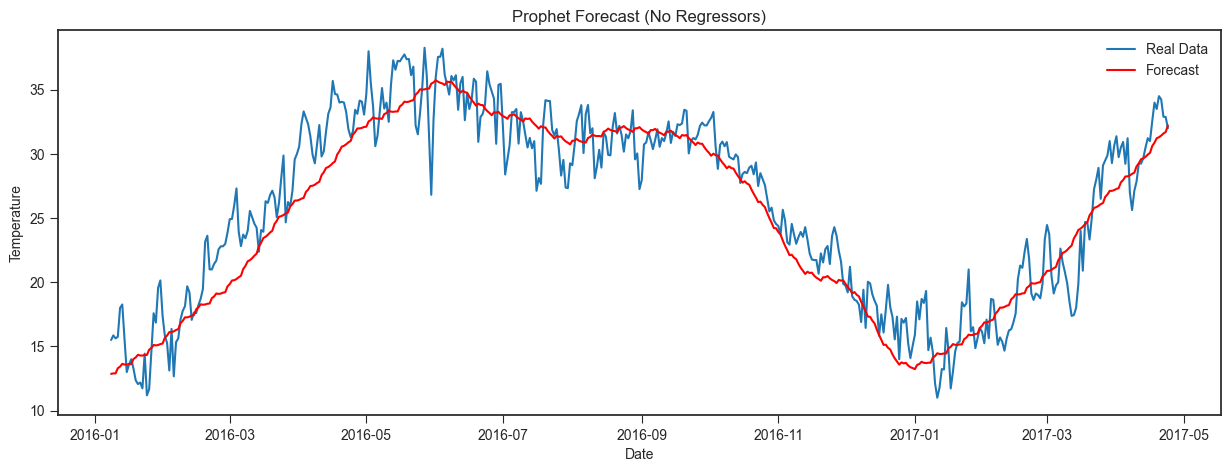

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Real Data')
plt.plot(predicted.index, predicted['yhat'], color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prophet Forecast (No Regressors)')
plt.legend()
plt.show()

### **Confidence interval of the forecast (with no regressors)**
---

The variables 'yhat_lower' and 'yhat_upper' represent the uncertainty intervals of the forecast. These intervals capture the range within which the actual values are likely to fall with a certain level of confidence. By default, Prophet provides 80% uncertainty intervals, which means that the upper and lower bounds (yhat_upper and yhat_lower) represent the range within which the actual values are expected to fall with 80% probability.

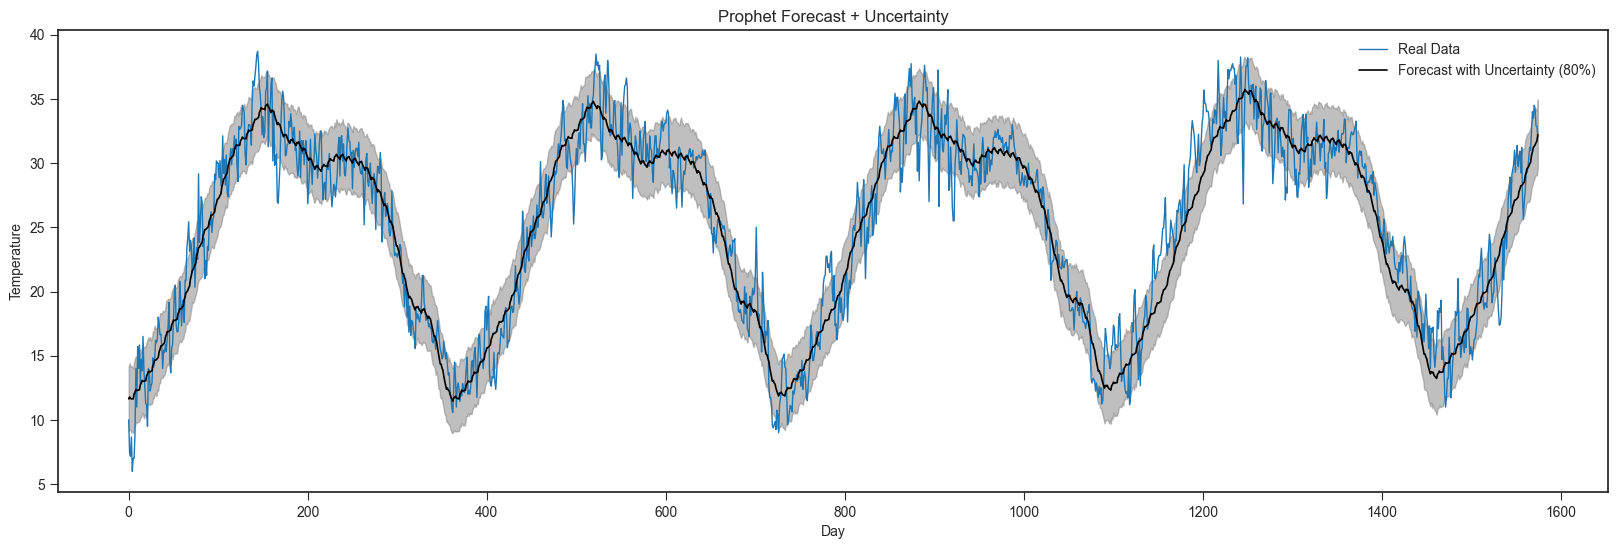

In [20]:
merged_df = pd.concat([train, test], ignore_index=True)
forecast['real_temp'] = merged_df['meantemp']
forecast.head()

plt.figure(figsize=(20, 6))

sns.lineplot(data=forecast['real_temp'], linewidth=1, label='Real Data')
sns.lineplot(data=forecast['yhat'], linewidth=1.2, color='black', label='Forecast with Uncertainty (80%)')
plt.fill_between(forecast.index, forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.5)

plt.legend()
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.title('Prophet Forecast + Uncertainty')

plt.show()

In [21]:
# Residuals of the model with no regressors and the real data
residuals = pd.DataFrame()
residuals['No Regressors'] = forecast.real_temp - forecast.yhat

### **Adding additional features to the model (humidity and wind speed)**
---
Now, we will use the entire dataset to train the model to take into account the humidity and wind speed in the prediction of temperature values.


In [22]:
# Second model
reg_model = Prophet()
reg_model.add_regressor('humidity')
reg_model.add_regressor('wind_speed')
reg_model.fit(train_prophet)  # Train

future = reg_model.make_future_dataframe(periods=len(test_prophet), freq='D')
future['humidity'] = df['humidity'].values
future['wind_speed'] = df['wind_speed'].values

forecast = reg_model.predict(future)
predicted = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

# Model performance
mse = mean_squared_error(test_prophet['y'], predicted['yhat'])
r2 = r2_score(test_prophet['y'], predicted['yhat'])
print(f'Test MSE: {mse}]')
print(f'Test R²: {r2}')

22:54:05 - cmdstanpy - INFO - Chain [1] start processing
22:54:05 - cmdstanpy - INFO - Chain [1] done processing


Test MSE: 4.253339482692729]
Test R²: 0.9149791044088712


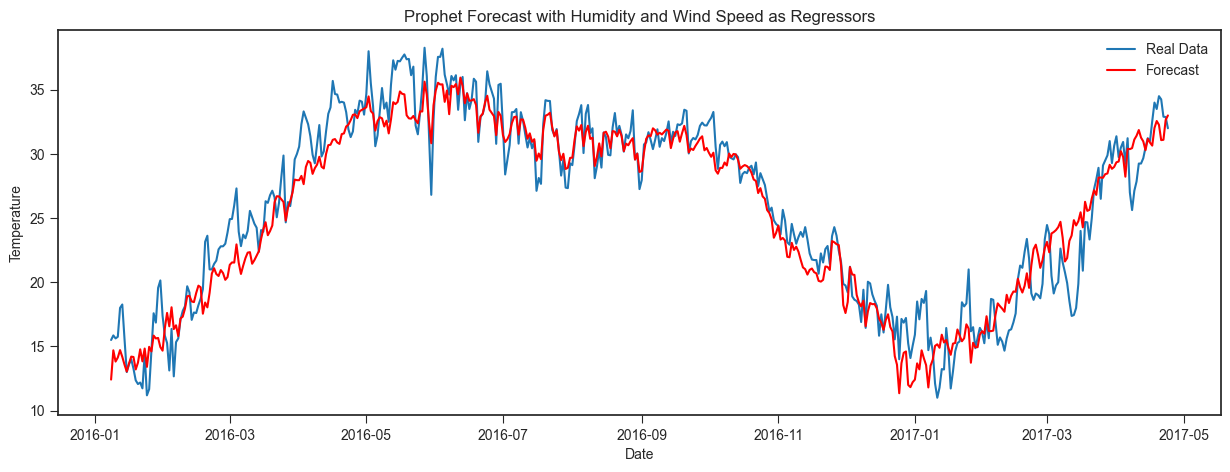

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Real Data')
plt.plot(predicted.index, predicted['yhat'], color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Prophet Forecast with Humidity and Wind Speed as Regressors')
plt.legend()
plt.show()

The overall fit of the model improves when humidity and wind speed are taken into account as regressor variables. This can be evaluated using the mean squared error (MSE) and the Goodness of Fit ($R^2$).

### **Confidence interval of the forecast (with regressors)**
---

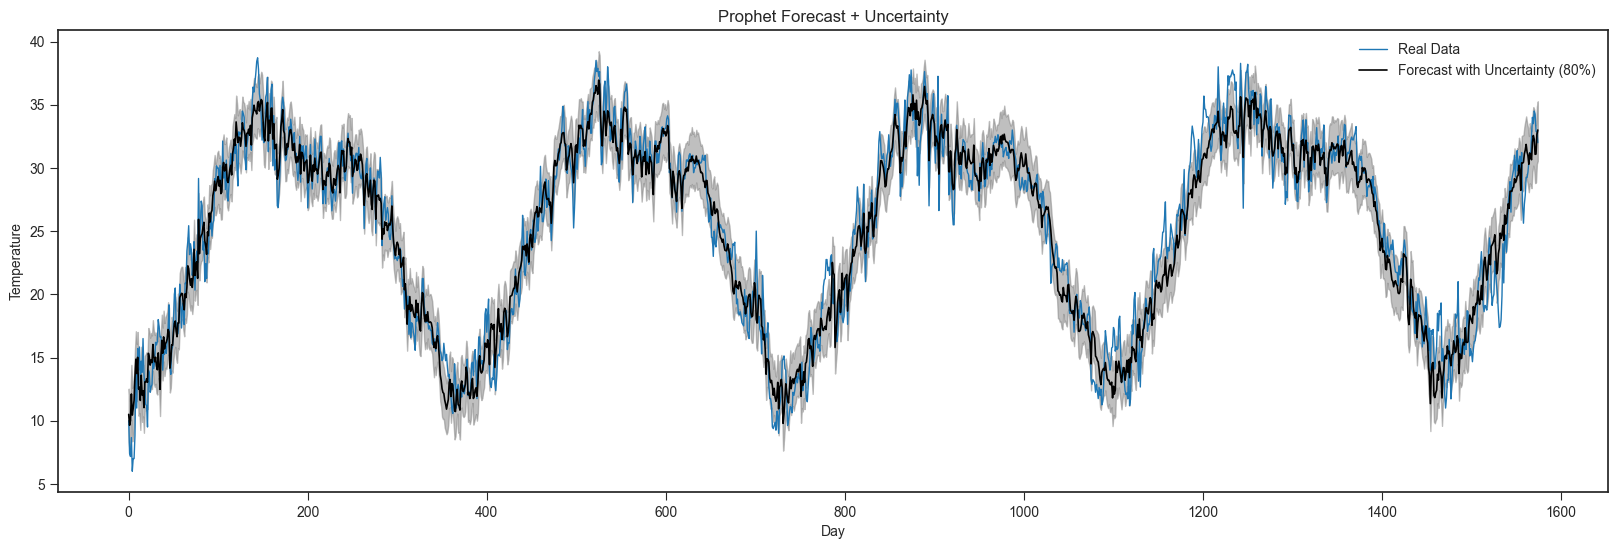

In [24]:
merged_df = pd.concat([train, test], ignore_index=True)
forecast['real_temp'] = merged_df['meantemp']
forecast.head()

plt.figure(figsize=(20, 6))

sns.lineplot(data=forecast['real_temp'], linewidth=1, label='Real Data')
sns.lineplot(data=forecast['yhat'], linewidth=1.2, color='black', label='Forecast with Uncertainty (80%)')
plt.fill_between(forecast.index, forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.5)

plt.legend()
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.title('Prophet Forecast + Uncertainty')

plt.show()

Including the regressor variables does not only improve the model, but also helps reducing the uncertainty interval.

In [25]:
# Residuals between the model with regressors and the real data
residuals['Regressors'] = forecast.real_temp - forecast.yhat

### **Residual distribution and comparison between models**
---
The residual is defined as the difference between the predicted and the real values. Normality of residuals means that they are distributed symmetrically around zero, with no skewness or kurtosis. This assumption implies that the model captures the main patterns and sources of variation in the data, and that the errors are random and independent. We can evaluate this using histograms, boxplots, and QQ plots.

In [26]:
residuals.head()

,No Regressors,Regressors
0,-1.638,-0.499
1,-4.383,-2.240
2,-4.508,-2.870
3,-2.967,-3.446
4,-5.647,-4.442


Both models have residuals with a fairly normal distribution. Note that the model with no regressors has a slightly possitive skew, while the model with regressors is almost perfectly symmetrical.

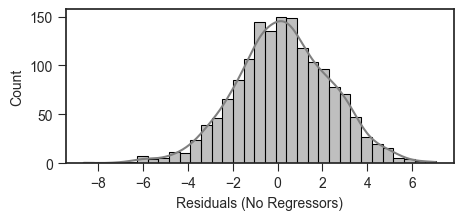

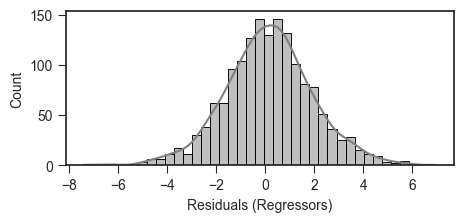

In [27]:
for column in residuals.columns:
        
    plt.figure(figsize=(5,2))
    plt.xlabel(f'Residuals ({column})', fontdict={'family':'arial'})
    sns.histplot(x = column, data = residuals, kde = True, color = 'gray')

While similar, the model with no regressors shows slightly higher residual values than the model with regressors (which is consistent with the $R^2$ values obtained previously).

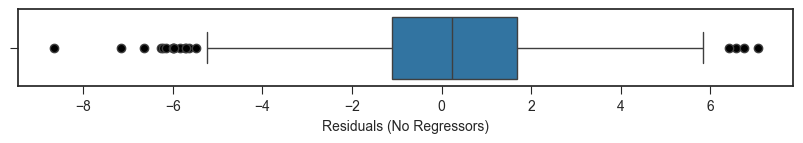

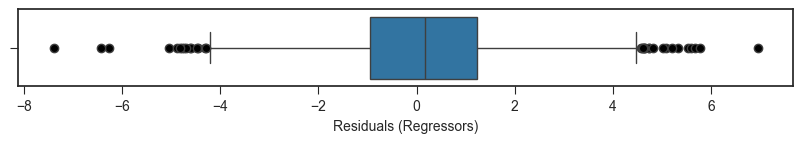

In [28]:
for column in residuals.columns:
        
    plt.figure(figsize=(10,1))
    plt.xlabel(f'Residuals ({column})', fontdict={'family':'arial'})
    sns.boxplot(x = column, data = residuals, flierprops=dict(markerfacecolor='black', marker='o')) 

Finally, with the QQ plots we can conclude that both models yield normal residual values.

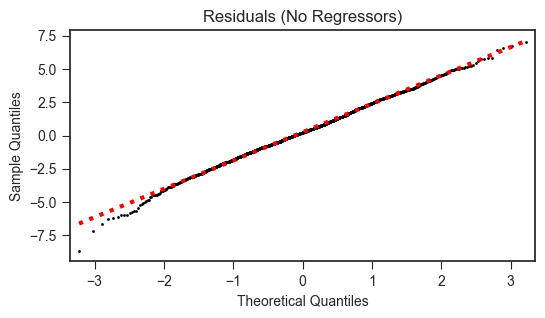

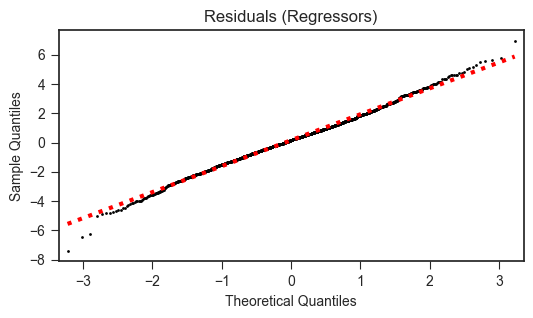

In [29]:
# We can also check for normality distribution of the data using a QQ plot
import statsmodels.api as sm

for column in residuals.columns:
    
    fig, ax = plt.subplots(figsize=(6, 3))
    sm.qqplot(residuals[column], line='s', markersize=2, ax=ax)
    ax.set_title(f'Residuals ({column})', fontdict={'family':'arial'})

    ax.get_lines()[0].set_markerfacecolor('black')  
    ax.get_lines()[0].set_markeredgecolor('none')  
    ax.get_lines()[1].set_color('red')  
    ax.get_lines()[1].set_linestyle('dotted') 
    ax.get_lines()[1].set_linewidth('3')

    plt.xlabel('Theoretical Quantiles', fontdict={'family':'arial'})
    plt.ylabel('Sample Quantiles', fontdict={'family':'arial'})

    plt.show()

### **Conclusions**
---
- Initially, we performed an exploratory data analysis to identify interesting correlations between the various parameters in the database. We modified and created auxiliary variables to facilitate the visualization of seasonal and annual trends. We selected the most important variables for building the predictive model, excluding those that did not provide relevant information for predicting the variable of interest. We determined that there is a slight upward trend in temperature and a slight downward trend in humidity over the years, using tools such as seasonal decomposition and correlation analysis.
- We found a strong negative correlation between humidity and temperature, which is amplified during months typically known to be hot and dry. Temperature also showed a moderate positive correlation with wind speed. Together, these variables proved useful for constructing the predictive model.
- Using Prophet, we initially built a simple model trained solely with temperature data. Subsequently, we added humidity and wind speed as regressor variables, thereby improving the model's performance (measured using parameters such as mean squared error and R squared).
- Finally, considering that the residual values should exhibit a normal distribution, we compared the residual distribution between the two constructed models. Consistent with previous results, the model with regressor variables showed, on average, residuals of smaller magnitude. Using QQ plots, we confirmed that both models presented a normal distribution of residuals.